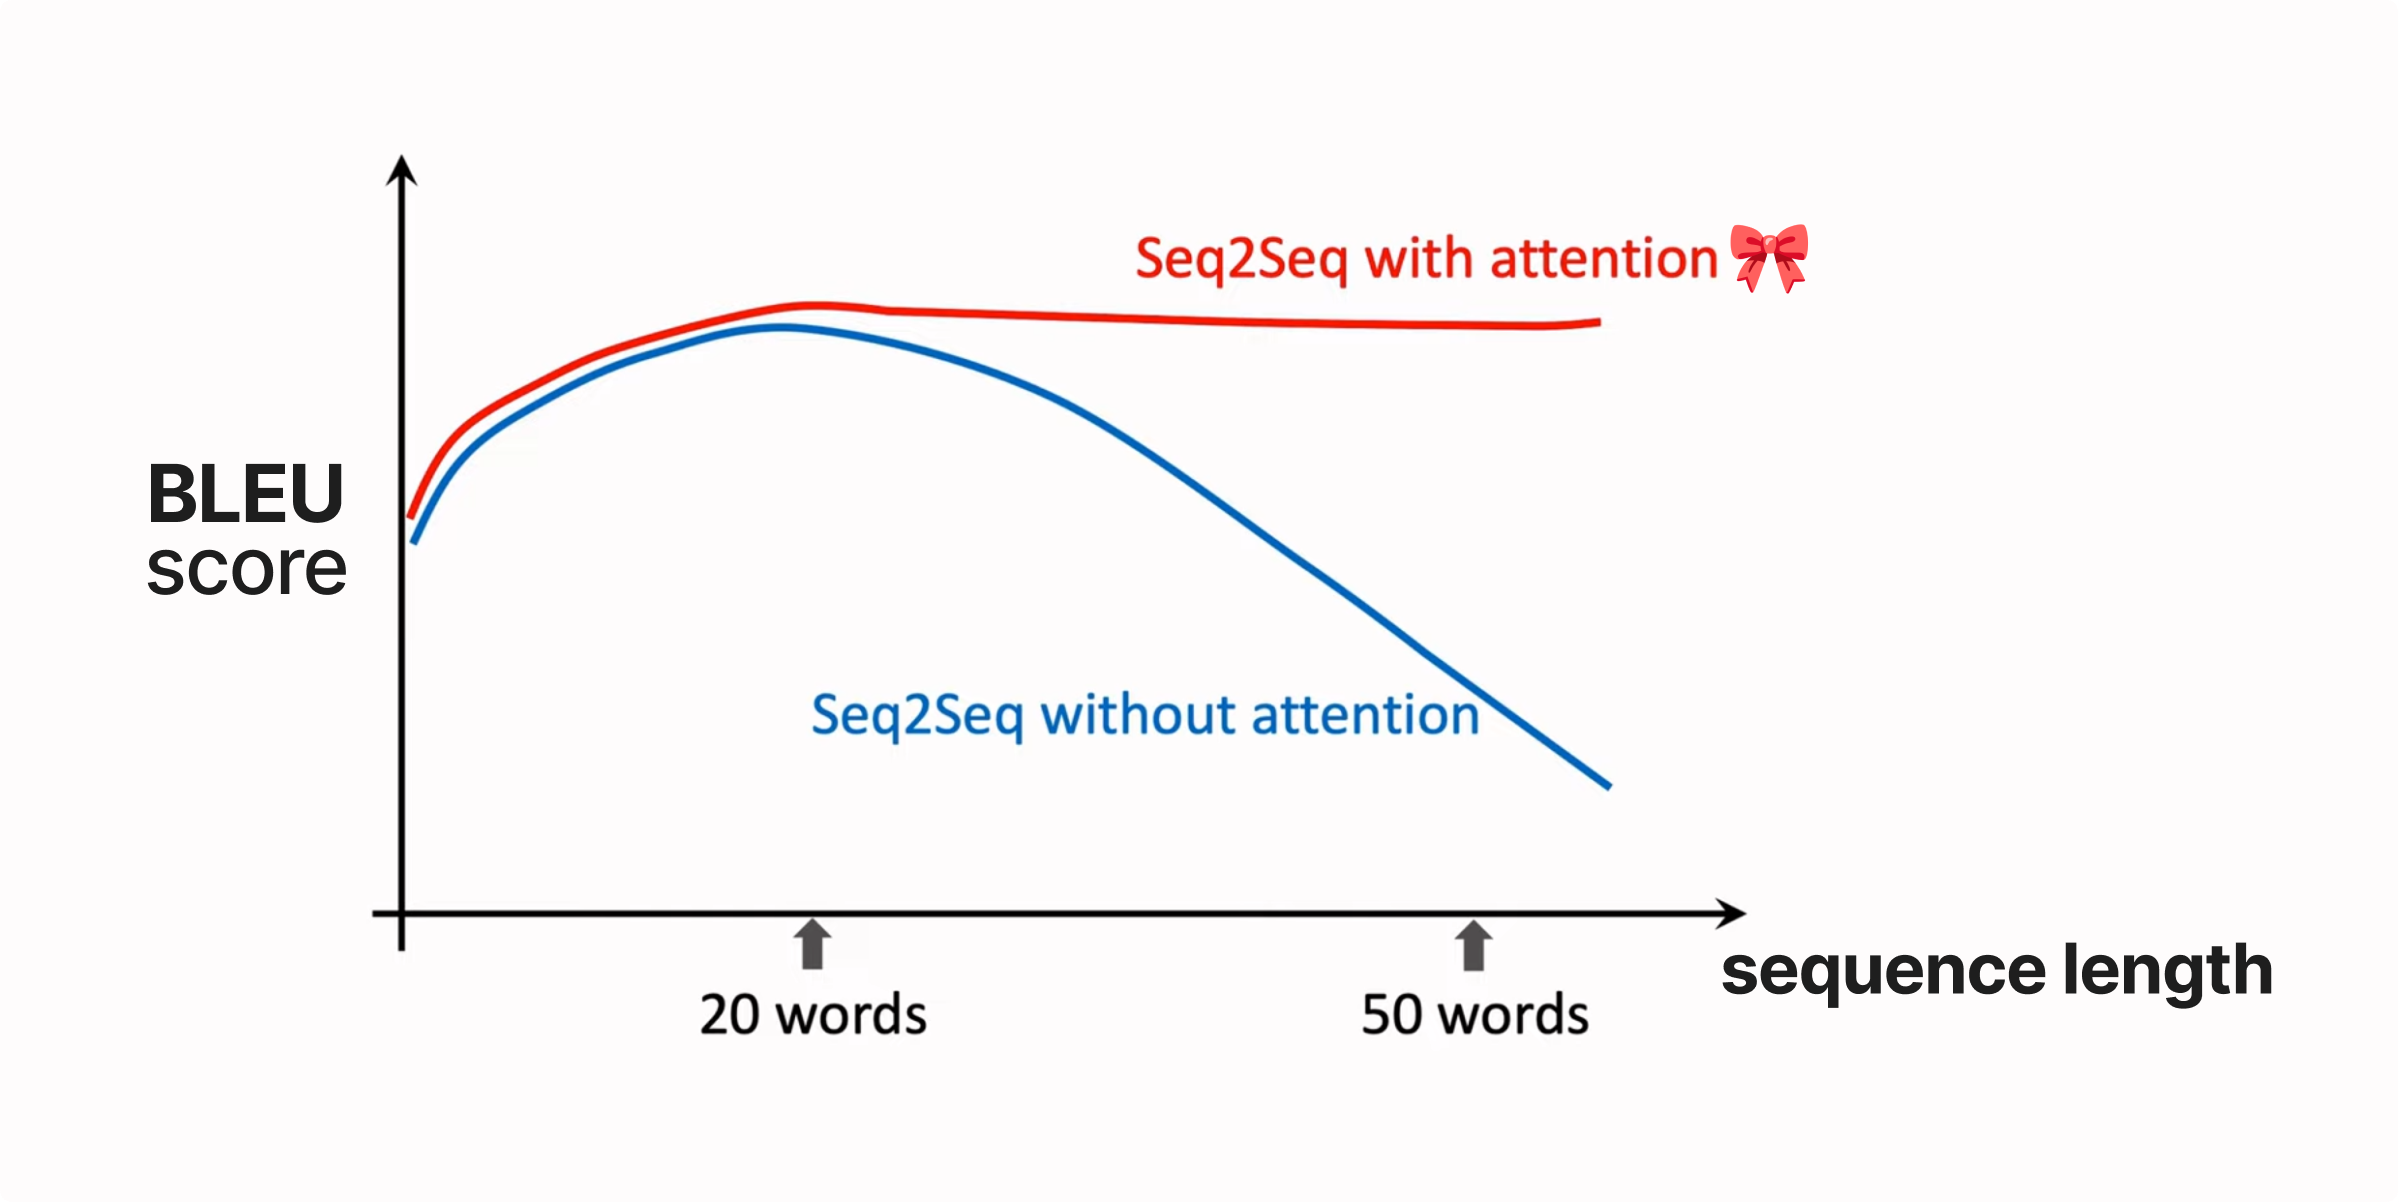

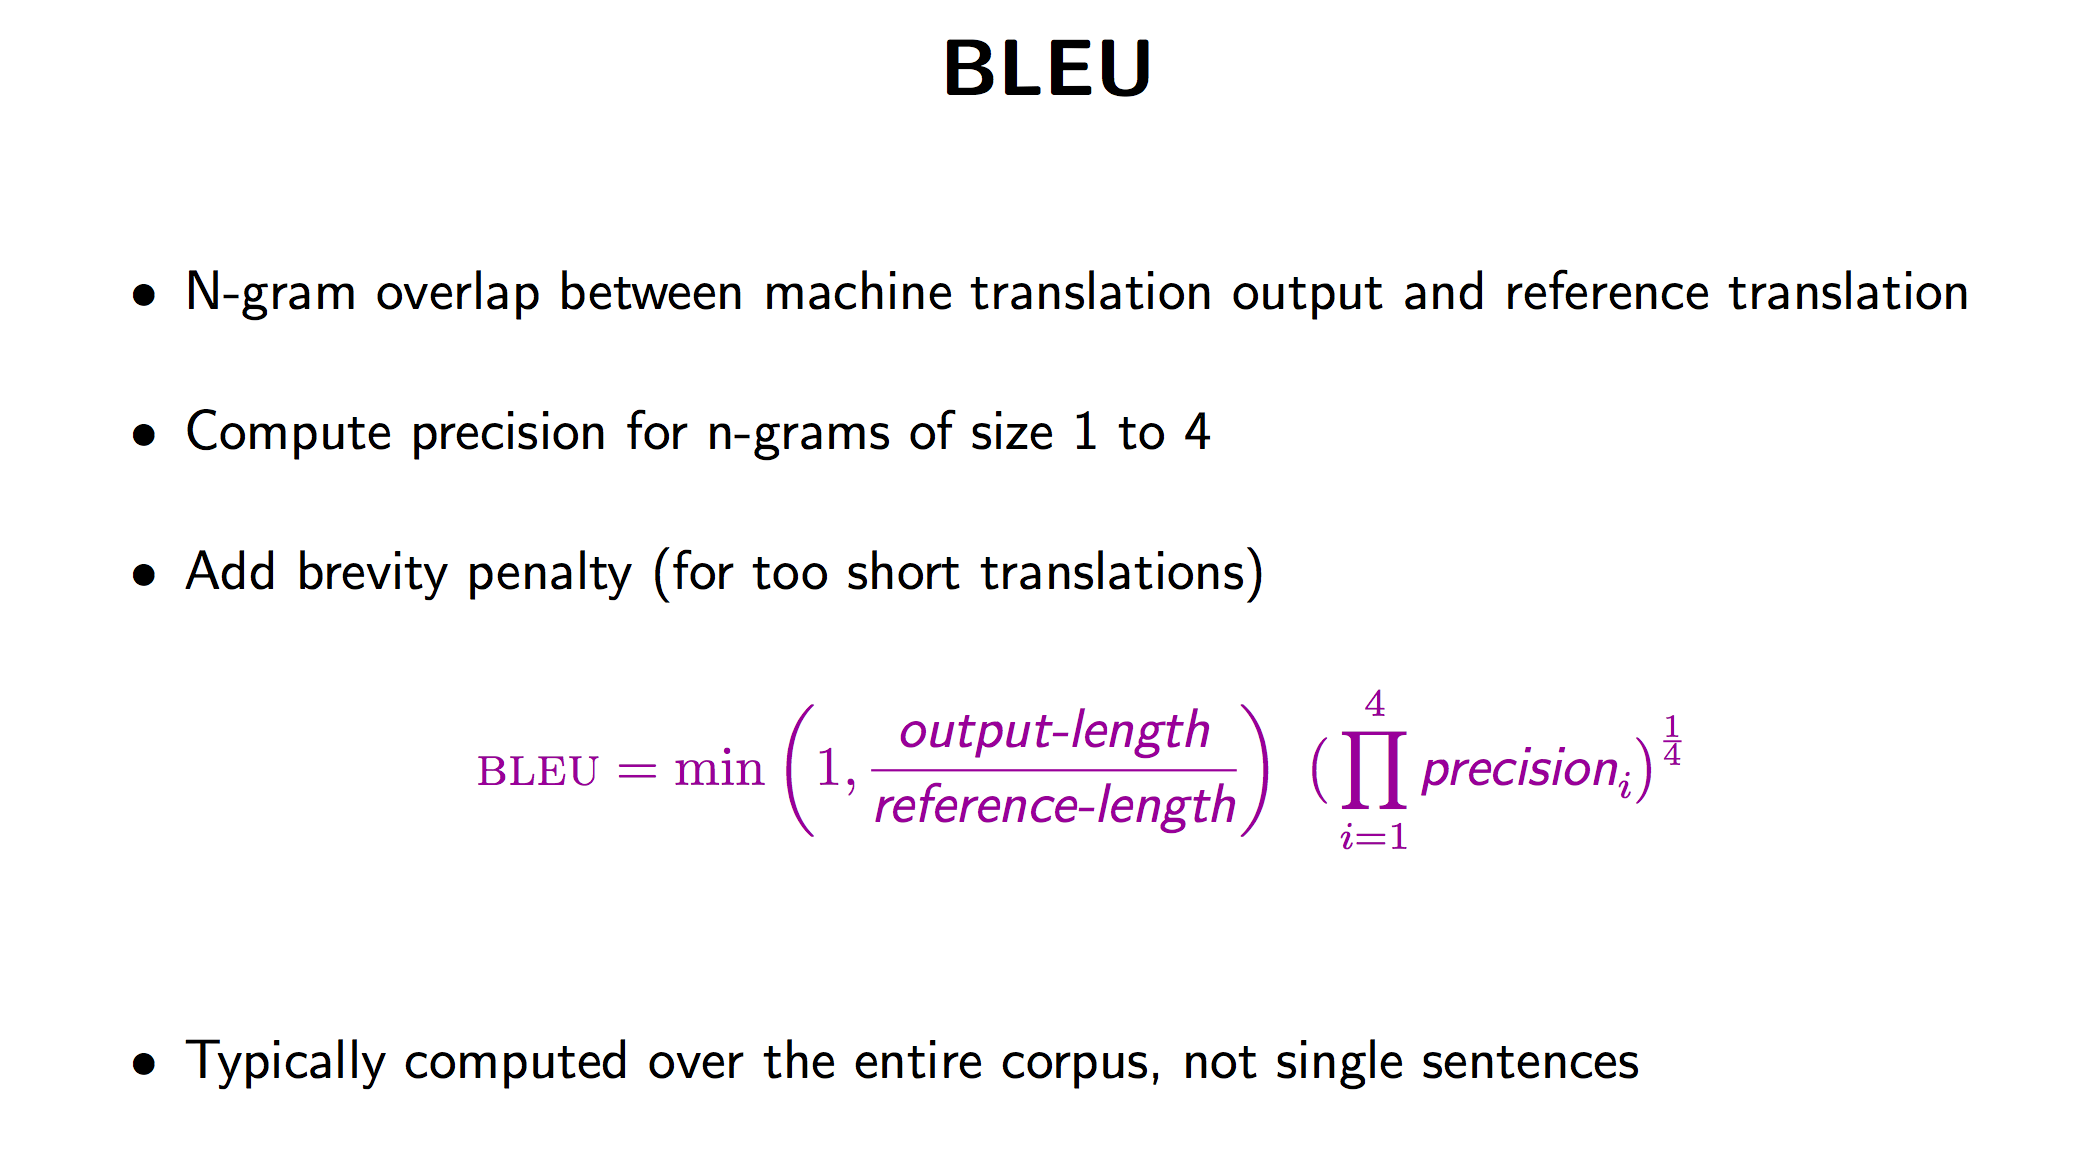

# seq2seq, but better

We'll introduce the trick discussed last time: teacher forcing...

...and something less violent and more exciting — attention!

[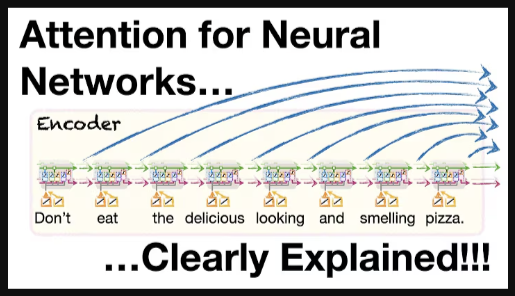](//www.youtube.com/watch?v=PSs6nxngL6k&t=60)

Why does attention help?

If only the context vector is passed between the encoder and decoder,
that single vector carries the burden of **encoding the entire sentence**.

If we rely solely on the context vector to encode the entire input sequence's meaning, it is likely that we will lose some information! This is especially the case when dealing with long input sequences, greatly limiting the capability of our decoder.

To combat this, in 2014 [Bahdanau et al.](//arxiv.org/pdf/1409.0473) created a mechanism that allows the decoder to pay attention to **certain parts** of the input sequence, rather than using the entire context at every step.

⚠️ **Attention!** The StatQuest above focuses on [Luong attention](//arxiv.org/pdf/1508.04025), a slightly different approach introduced later, building on Bahdanau's work

The main difference: Luong attention calculates the alignment using the **current** state of the decoder, while Bahdanau uses **the state at t-1**.



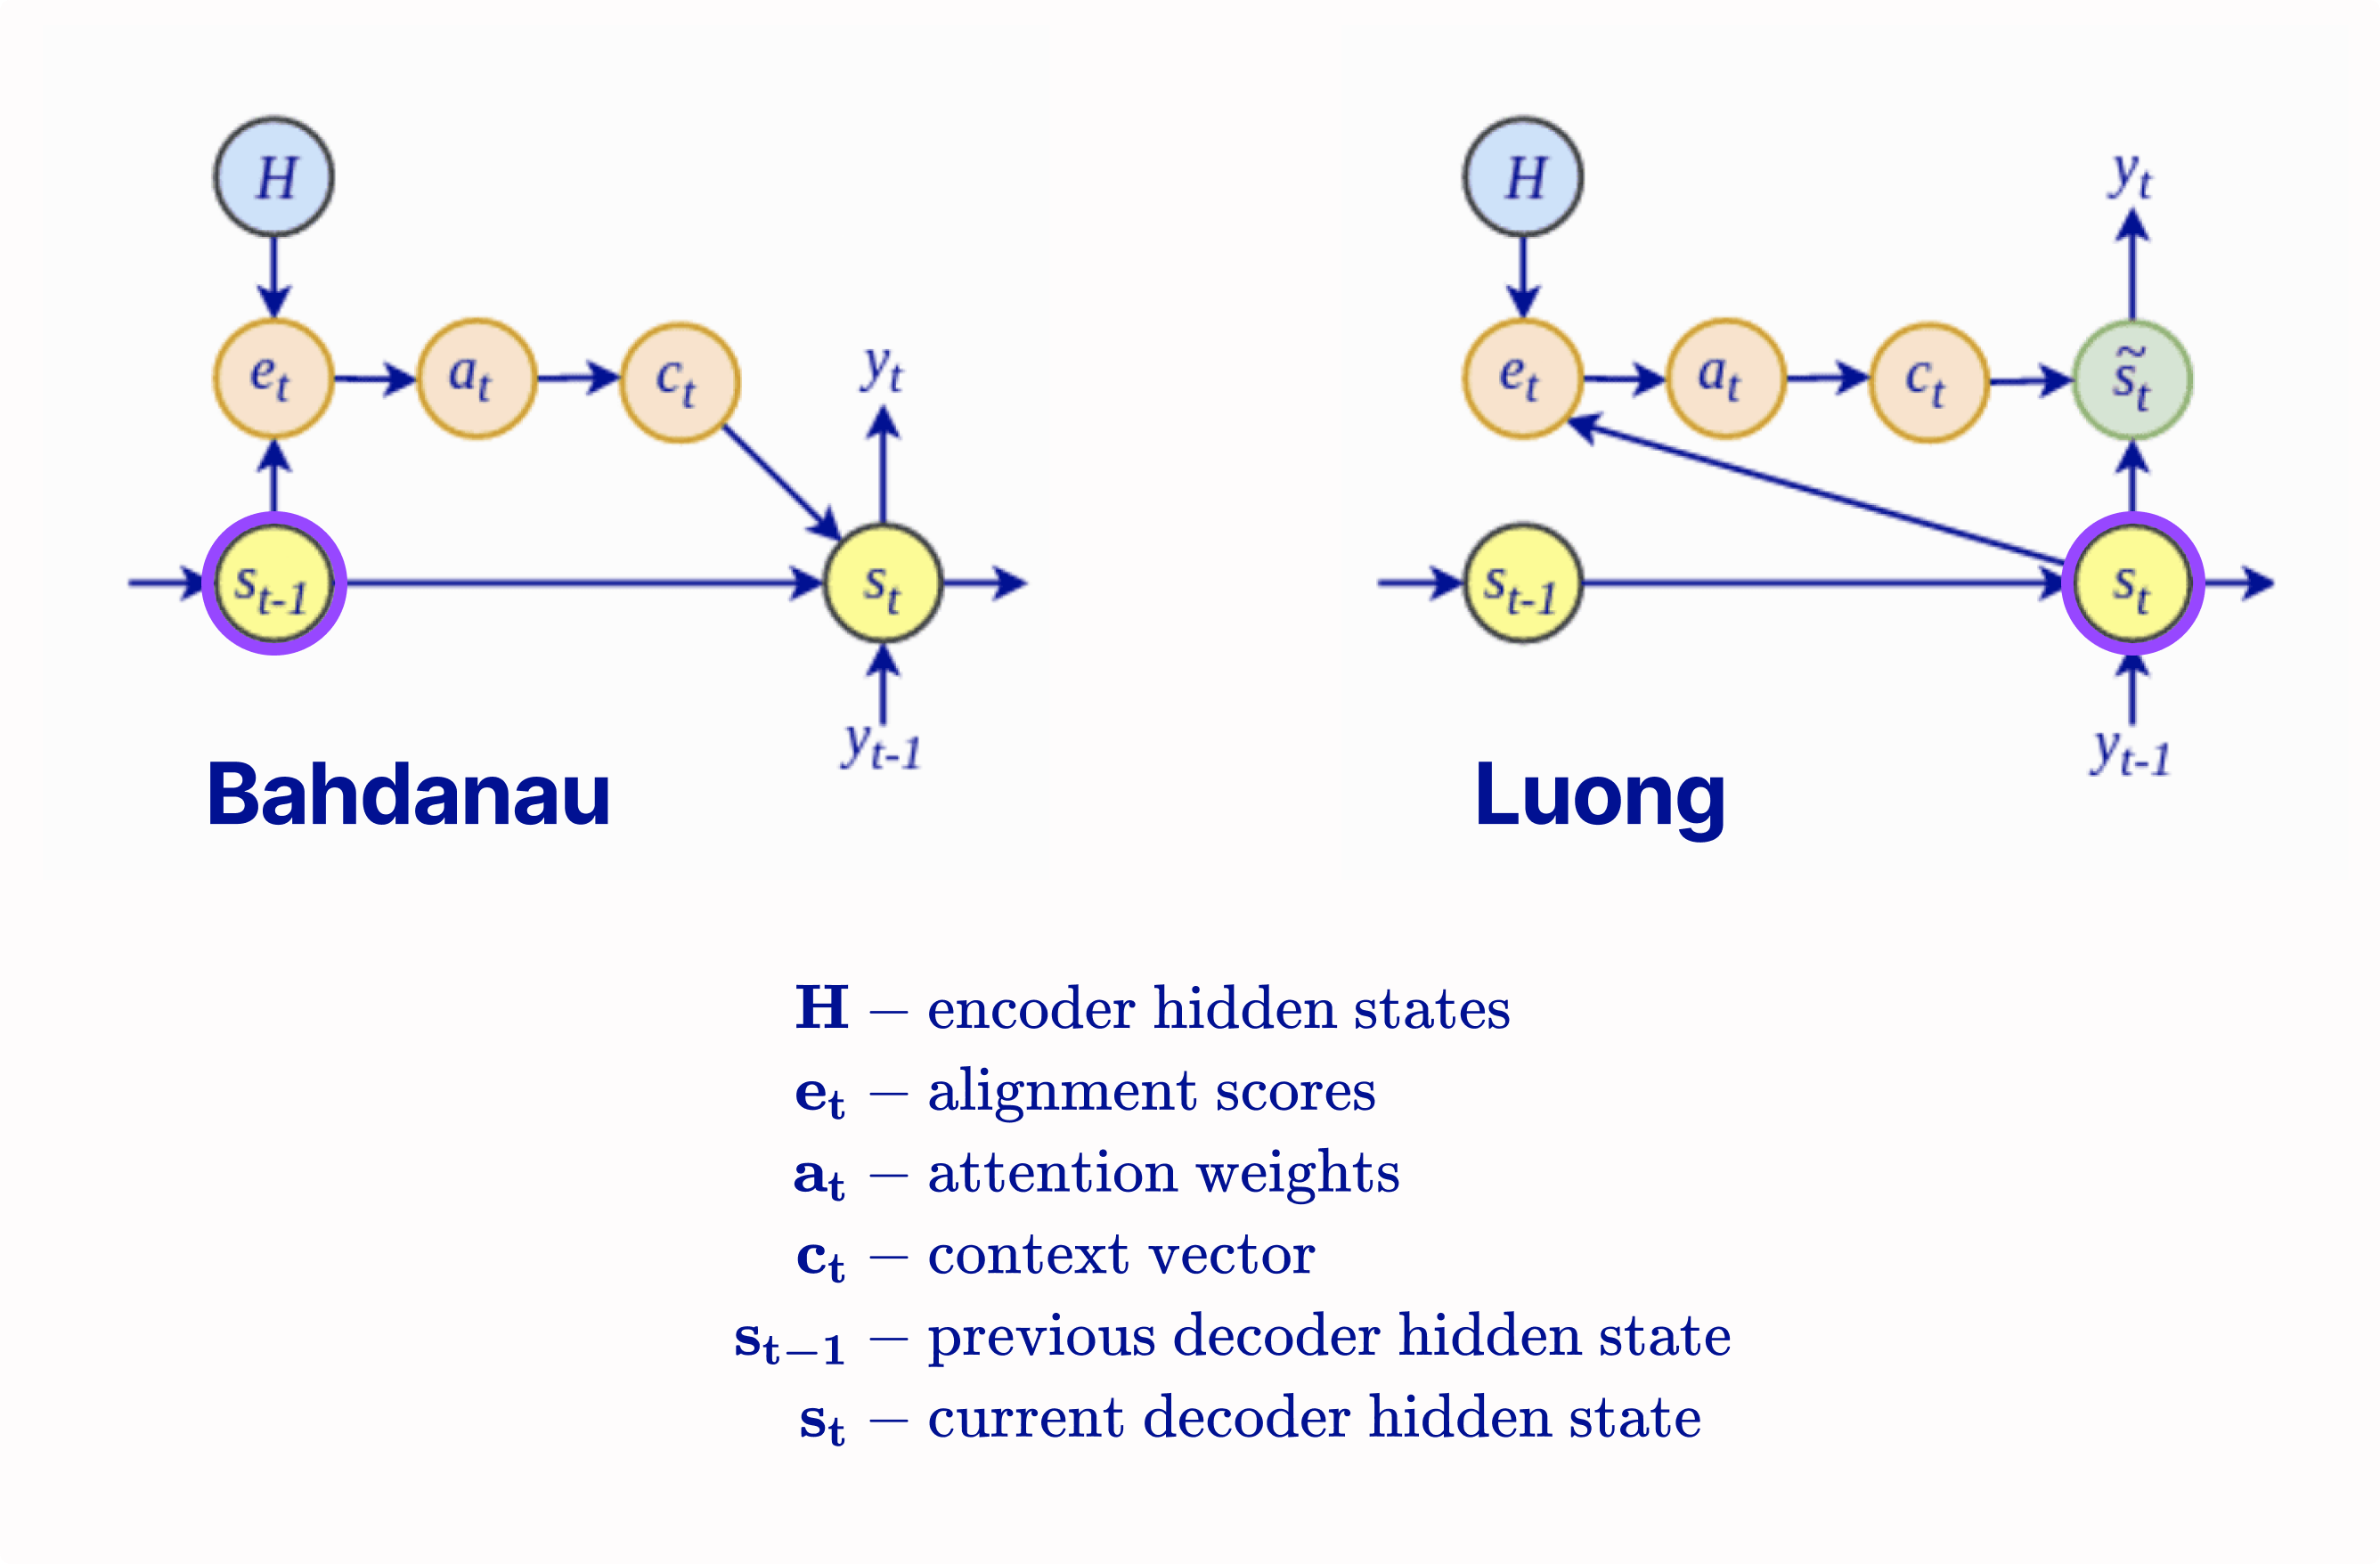

## Getting data + defining the **encoder** from the previous lab
Just run this without expanding the section if you remember the setup

(otherwise make sure you understand what happened in [Lab 10](//colab.research.google.com/drive/1SSdUHd4QP_9llkBjQjRdK5BGggw0lzGG?usp=sharing) first!)

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data

--2025-01-05 20:08:33--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.10.76, 18.160.10.36, 18.160.10.28, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.10.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.02s   

2025-01-05 20:08:33 (131 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['vous etes tres avise', 'you re very wise']


In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

## Adding attention to the **decoder**



</br>

At a high level, attention is calculated using the decoder's current hidden state and the encoder's outputs. The output attention weights have the same shape as the encoder's outputs, allowing us to multiply them by the encoder outputs, giving us a weighted sum which indicates the parts of encoder output to pay attention to. Sean Robertson's figure describes this very well:

![](https://pytorch.org/tutorials/_images/attn2.png)

Calculating the attention weights is done with a feed-forward
layer `attn`, using the decoder\'s input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.



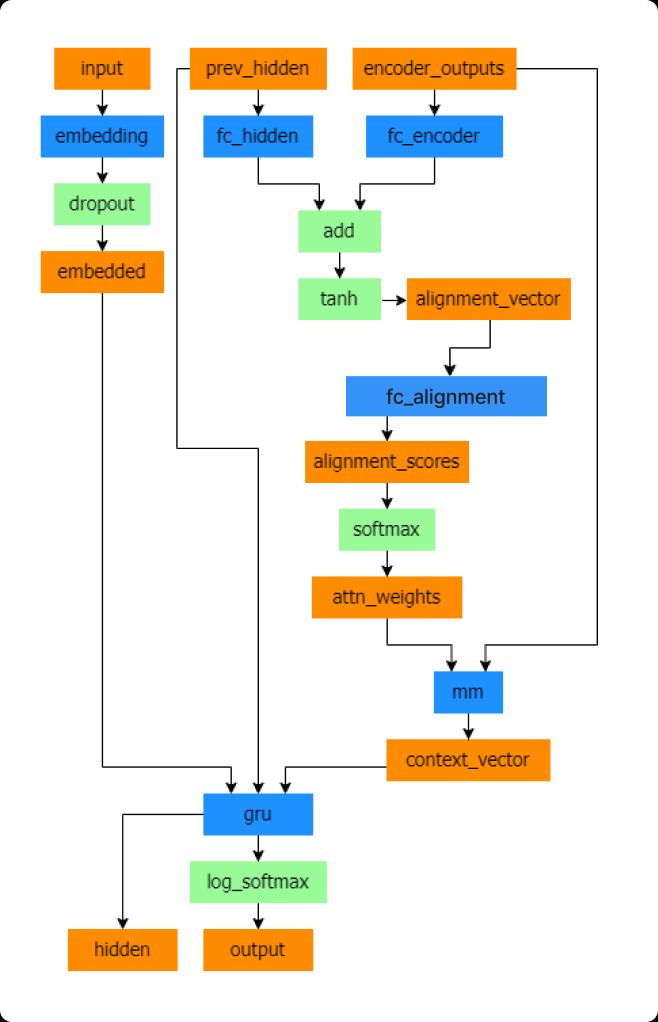



Bahdanau attention, also known as additive attention, is a commonly used
attention mechanism in sequence-to-sequence models, particularly in
neural machine translation tasks. It was introduced by Bahdanau et al.
in their paper titled [Neural Machine Translation by Jointly Learning to
Align and Translate](https://arxiv.org/pdf/1409.0473.pdf). This
attention mechanism employs a learned alignment model to compute
attention scores between the encoder and decoder hidden states. It
utilizes a feed-forward neural network to calculate alignment scores.

However, there are alternative attention mechanisms available, such as
Luong attention, which computes attention scores by taking the dot
product between the decoder hidden state and the encoder hidden states.
It does not involve the non-linear transformation used in Bahdanau
attention.

In this tutorial, we will be using Bahdanau attention. However, it would
be a valuable exercise to explore modifying the attention mechanism to
use Luong attention.

In [ ]:

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.fc_hidden = nn.Linear(hidden_size, hidden_size)
        self.fc_encoder = nn.Linear(hidden_size, hidden_size)
        self.fc_alignment = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        alignment_vector = torch.tanh(self.fc_hidden(query) + self.fc_encoder(keys))
        scores = self.fc_alignment(alignment_vector)
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights



## Continuing with the training just like last time

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
from tqdm import tqdm

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in tqdm(range(1, n_epochs + 1)):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, _ = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> je suis simplement franc
= i m just being honest
< i m just being honest <EOS>

> nous sommes speciaux
= we re special
< we re special <EOS>

> je suis completement epuise
= i m completely exhausted
< i m completely exhausted <EOS>

> vous etes tres riches
= you are very rich
< you are rich rich <EOS>

> vous etes vraiment apre au travail
= you re really a hard worker
< you re really a hard worker <EOS>

> elle a tres peur du noir
= she is very afraid of the dark
< she is very afraid of the dark afraid <EOS>

> il ne cesse de me surprendre
= i m always surprised by him
< i m always surprised by him <EOS>

> vous etes plus grandes que moi
= you re taller than i am
< you re taller than i am <EOS>

> je le connais bien
= i am well acquainted with him
< i am well acquainted with him <EOS>

> il est connu pour etre un grand peintre
= he is known as a great painter
< he is known as a great painter <EOS>



In [ ]:
enc_path = "enc_seq2seq_attention.pth"
dec_path = "dec_seq2seq_attention.pth"
torch.save(encoder.state_dict(), enc_path)
torch.save(decoder.state_dict(), dec_path)


In [ ]:
from google.colab import files

files.download(enc_path)
files.download(dec_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# if you want to load the saved parameters

enc = EncoderRNN(input_lang.n_words, hidden_size)  # first initialize the model
enc.load_state_dict(torch.load("enc_seq2seq_attention.pth", map_location=torch.device('cpu')))  # then load
enc.eval() # don't forget about the evaluation mode!

dec = AttnDecoderRNN(hidden_size, output_lang.n_words)  # first initialize the model
dec.load_state_dict(torch.load("dec_seq2seq_attention.pth", map_location=torch.device('cpu')))  # then load
dec.eval() # don't forget about the evaluation mode!


<ipython-input-29-2ea74e043e7d>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  enc.load_state_dict(torch.load("enc_seq2seq_attention.pth", map_location=torch.device('cpu')

AttnDecoderRNN(
  (embedding): Embedding(2991, 128)
  (attention): BahdanauAttention(
    (fc_hidden): Linear(in_features=128, out_features=128, bias=True)
    (fc_encoder): Linear(in_features=128, out_features=128, bias=True)
    (fc_alignment): Linear(in_features=128, out_features=1, bias=True)
  )
  (gru): GRU(256, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=2991, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
evaluate(enc, dec, "elle est trop heureuse", input_lang, output_lang)

['she', 'is', 'too', 'happy', 'too', '<EOS>']

# (Re)Sources

- StatQuest on attention [here](//www.youtube.com/watch?v=PSs6nxngL6k) (he's describing Luong attention)

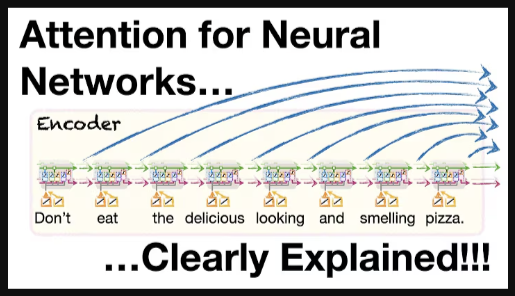

- great blog-post explanations by Jason Brownlee: Bahdanau attention [here](//machinelearningmastery.com/the-bahdanau-attention-mechanism/) and Luong attention [here](//machinelearningmastery.com/the-luong-attention-mechanism/)